In [1]:
import pickle
X_acl,X_ppg,y,y_participant = pickle.load(open('../data/tabular_data.p','rb'))

In [2]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler

for k in range(X_ppg.shape[0]):
    X_ppg[k] = MinMaxScaler().fit_transform(X_ppg[k])

import numpy as np
X_ppg = X_ppg[:,np.arange(0,512,2),:]

X_acl = np.concatenate([X_ppg,X_acl],axis=-1)[:,:,:]

y = X_ppg[:,:,0].reshape(-1,256,1)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut,LeavePGroupsOut
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib notebook
from keras.layers import Conv1D,Attention,Reshape,BatchNormalization,TimeDistributed, \
Dropout,Input,MaxPooling1D,Flatten,Dense,Input, GaussianNoise,LSTM, Bidirectional, Input
from keras.models import Model, Sequential

In [4]:
logo = LeaveOneGroupOut()
logo = LeavePGroupsOut(n_groups=5)
for train_index, test_index in logo.split(X_acl, y, y_participant.reshape(-1)):
    train_x, test_x = X_acl[train_index], X_acl[test_index]
    train_y, test_y = y[train_index], y[test_index]
    train_participant, test_participant = y_participant[train_index], y_participant[test_index]
    break
train_x.shape,train_y.shape

((29067, 256, 4), (29067, 256, 1))

In [5]:
train_x, val_x, train_y, val_y = train_test_split(train_x,train_y,test_size = 0.2,random_state=42)

(train_x.shape, train_y.shape), (val_x.shape, val_y.shape),(test_x.shape,test_y.shape)

(((23253, 256, 4), (23253, 256, 1)),
 ((5814, 256, 4), (5814, 256, 1)),
 ((14296, 256, 4), (14296, 256, 1)))

In [121]:
from keras_self_attention import SeqSelfAttention
from keras import backend as K
from keras.layers import Concatenate, Flatten,LeakyReLU, Activation, RepeatVector, Permute, Multiply, Lambda, Dense, merge# Define a regular layer instead of writing a custom layer
# This layer should have just one neuron - like before
# The weights and bias shapes are automatically calculated 
# by the Framework, based on the input
# This layer is defined at step 3.5 directly

def custom_loss(y_true,y_pred):
    y_pred_attention = 1+y_pred[:,:,1]
    y_pred = y_pred[:,:,0]
    y_true = y_true[:,:,0]
    loss = K.mean(K.abs(y_true-y_pred)*y_pred_attention)
    return loss


def get_model(input_shape=(256,4),act='relu',loss="mae",opt='adam',n_classes=1):
#     model =  Sequential()
#     model.add(GaussianNoise(1))
#     model.add(Conv1D(100,20,activation='linear',kernel_initializer='normal',padding='same'))
#     model.add(Conv1D(10,10,activation='relu',kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    
    model2 =  Sequential()
    model2.add(Conv1D(100,20,activation=act,kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    model2.add(MaxPooling1D(5))
    model2.add(BatchNormalization())
    model2.add(Dropout(.2))
    model2.add(Conv1D(100,20,activation=act,kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    model2.add(MaxPooling1D(5))
    model2.add(BatchNormalization())
    model2.add(Dropout(.2))
    model2.add(Conv1D(50,20,activation=act,kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    model2.add(MaxPooling1D(2))
    model2.add(BatchNormalization())
    model2.add(Flatten())
    model2.add(Dense(8,activation='relu'))
    model2.add(Reshape((4,2)))
    model2.add(Conv1D(100,2,input_shape=input_shape,activation=act,kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    model2.add(BatchNormalization())
    model2.add(Dropout(.2))
    model2.add(Conv1D(256,2,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model2.add(Permute([2,1]))
#     model2.add(TimeDistributed(Dense(1,activation='relu')))
    
#     model2.add(Flatten())
#     model2.add(Dense(20,activation='relu'))
#     model2.add(Dense(128,activation='relu'))
#     model2.add(Dense(256,activation='relu'))
#     model2.add(Reshape((256,1)))
    model2.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model2.add(Conv1D(10,10,activation='tanh',kernel_initializer='normal',padding='same'))
#     model2.add(BatchNormalization())
    model2.add(TimeDistributed(Dense(1,activation='linear')))
    
    x = Input(shape=input_shape)
    x_encoded = Conv1D(100,32,activation='sigmoid',kernel_initializer='normal',padding='same')(x)
#     e=Dense(1, activation='sigmoid')(x_encoded)# Now do all the softmax business taking the above o/p
#     e=Dense(1, activation='sigmoid')(e)
    e = Conv1D(1,64,activation='sigmoid',kernel_initializer='normal',padding='same')(x_encoded)
    
    e=Flatten()(e)
    a=Activation('softmax')(e)
    a = a*256
    temp=RepeatVector(100)(a)
    temp=Permute([2, 1])(temp)# multiply weight with lstm layer o/p
    output = merge.Multiply()([x_encoded, temp])
    output = model2(output)
    a1 = RepeatVector(1)(a)
    a1 = Permute([2, 1])(a1)
    output = Concatenate()([output,a1])
    model1 = Model(inputs=x,outputs=output)
    model1.compile(loss=custom_loss,optimizer=opt)
    return model1

    
    
#     model.add(Bidirectional(LSTM(100,return_sequences=True,activation='tanh',kernel_initializer='normal')))
#     model.add(TimeDistributed(Dense(1,activation='')))
    

In [122]:
model = get_model()
model.summary()
model_json = model.to_json()
from keras.models import load_model
filepath = '../model_files/convolutional_autoencoder_weights.hdf5'
model_filepath = '../model_files/convolutional_autoencoder.json'
with open(model_filepath, "w") as json_file:
    json_file.write(model_json)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 256, 4)]     0                                            
__________________________________________________________________________________________________
conv1d_219 (Conv1D)             (None, 256, 100)     12900       input_28[0][0]                   
__________________________________________________________________________________________________
conv1d_220 (Conv1D)             (None, 256, 1)       6401        conv1d_219[0][0]                 
__________________________________________________________________________________________________
flatten_55 (Flatten)            (None, 256)          0           conv1d_220[0][0]                 
___________________________________________________________________________________________

In [123]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
callbacks_list = [es,checkpoint]
history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=500, batch_size=500,
          callbacks=callbacks_list,shuffle=True)

Epoch 1/500
46/47 [============================>.] - ETA: 0s - loss: 0.4060
Epoch 00001: val_loss improved from inf to 0.35334, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 2s 53ms/step - loss: 0.4050 - val_loss: 0.3533
Epoch 2/500
47/47 [==============================] - ETA: 0s - loss: 0.3143
Epoch 00002: val_loss did not improve from 0.35334
47/47 [==============================] - 2s 50ms/step - loss: 0.3143 - val_loss: 0.4955
Epoch 3/500
47/47 [==============================] - ETA: 0s - loss: 0.3088
Epoch 00003: val_loss did not improve from 0.35334
47/47 [==============================] - 2s 50ms/step - loss: 0.3088 - val_loss: 0.4981
Epoch 4/500
47/47 [==============================] - ETA: 0s - loss: 0.3063
Epoch 00004: val_loss did not improve from 0.35334
47/47 [==============================] - 2s 50ms/step - loss: 0.3063 - val_loss: 0.5114
Epoch 5/500
47/47 [==============================] - ETA: 0s - loss: 

47/47 [==============================] - ETA: 0s - loss: 0.2182
Epoch 00034: val_loss did not improve from 0.21214
47/47 [==============================] - 2s 51ms/step - loss: 0.2182 - val_loss: 0.2146
Epoch 35/500
47/47 [==============================] - ETA: 0s - loss: 0.2173
Epoch 00035: val_loss did not improve from 0.21214
47/47 [==============================] - 2s 51ms/step - loss: 0.2173 - val_loss: 0.2125
Epoch 36/500
47/47 [==============================] - ETA: 0s - loss: 0.2167
Epoch 00036: val_loss did not improve from 0.21214
47/47 [==============================] - 2s 50ms/step - loss: 0.2167 - val_loss: 0.2161
Epoch 37/500
46/47 [============================>.] - ETA: 0s - loss: 0.2157
Epoch 00037: val_loss did not improve from 0.21214
47/47 [==============================] - 2s 51ms/step - loss: 0.2157 - val_loss: 0.2235
Epoch 38/500
47/47 [==============================] - ETA: 0s - loss: 0.2155
Epoch 00038: val_loss did not improve from 0.21214
47/47 [==============

Epoch 68/500
46/47 [============================>.] - ETA: 0s - loss: 0.1981
Epoch 00068: val_loss improved from 0.19428 to 0.19343, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 2s 52ms/step - loss: 0.1982 - val_loss: 0.1934
Epoch 69/500
47/47 [==============================] - ETA: 0s - loss: 0.1987
Epoch 00069: val_loss did not improve from 0.19343
47/47 [==============================] - 2s 51ms/step - loss: 0.1987 - val_loss: 0.1941
Epoch 70/500
46/47 [============================>.] - ETA: 0s - loss: 0.1979
Epoch 00070: val_loss improved from 0.19343 to 0.19342, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 2s 51ms/step - loss: 0.1979 - val_loss: 0.1934
Epoch 71/500
47/47 [==============================] - ETA: 0s - loss: 0.1976
Epoch 00071: val_loss did not improve from 0.19342
47/47 [==============================] - 2s 51ms/step - loss: 0.1976 - val

47/47 [==============================] - 2s 52ms/step - loss: 0.1925 - val_loss: 0.1895
Epoch 103/500
47/47 [==============================] - ETA: 0s - loss: 0.1928
Epoch 00103: val_loss did not improve from 0.18946
47/47 [==============================] - 2s 51ms/step - loss: 0.1928 - val_loss: 0.1896
Epoch 104/500
46/47 [============================>.] - ETA: 0s - loss: 0.1928
Epoch 00104: val_loss did not improve from 0.18946
47/47 [==============================] - 2s 51ms/step - loss: 0.1929 - val_loss: 0.1947
Epoch 105/500
46/47 [============================>.] - ETA: 0s - loss: 0.1924
Epoch 00105: val_loss improved from 0.18946 to 0.18830, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 2s 52ms/step - loss: 0.1924 - val_loss: 0.1883
Epoch 106/500
46/47 [============================>.] - ETA: 0s - loss: 0.1934
Epoch 00106: val_loss did not improve from 0.18830
47/47 [==============================] - 2s 51ms/step - l

Epoch 138/500
47/47 [==============================] - ETA: 0s - loss: 0.1893
Epoch 00138: val_loss did not improve from 0.18658
47/47 [==============================] - 2s 51ms/step - loss: 0.1893 - val_loss: 0.1875
Epoch 139/500
47/47 [==============================] - ETA: 0s - loss: 0.1896
Epoch 00139: val_loss improved from 0.18658 to 0.18650, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 2s 51ms/step - loss: 0.1896 - val_loss: 0.1865
Epoch 140/500
47/47 [==============================] - ETA: 0s - loss: 0.1898
Epoch 00140: val_loss improved from 0.18650 to 0.18606, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 2s 52ms/step - loss: 0.1898 - val_loss: 0.1861
Epoch 141/500
46/47 [============================>.] - ETA: 0s - loss: 0.1898
Epoch 00141: val_loss did not improve from 0.18606
47/47 [==============================] - 2s 51ms/step - loss: 0.1899 -

47/47 [==============================] - ETA: 0s - loss: 0.1874
Epoch 00173: val_loss did not improve from 0.18477
47/47 [==============================] - 2s 51ms/step - loss: 0.1874 - val_loss: 0.1852
Epoch 174/500
46/47 [============================>.] - ETA: 0s - loss: 0.1877
Epoch 00174: val_loss did not improve from 0.18477
47/47 [==============================] - 2s 51ms/step - loss: 0.1876 - val_loss: 0.1899
Epoch 175/500
47/47 [==============================] - ETA: 0s - loss: 0.1875
Epoch 00175: val_loss did not improve from 0.18477
47/47 [==============================] - 2s 51ms/step - loss: 0.1875 - val_loss: 0.1855
Epoch 176/500
47/47 [==============================] - ETA: 0s - loss: 0.1875
Epoch 00176: val_loss did not improve from 0.18477
47/47 [==============================] - 2s 51ms/step - loss: 0.1875 - val_loss: 0.1877
Epoch 177/500
46/47 [============================>.] - ETA: 0s - loss: 0.1874
Epoch 00177: val_loss did not improve from 0.18477
47/47 [==========

Epoch 208/500
46/47 [============================>.] - ETA: 0s - loss: 0.1865
Epoch 00208: val_loss did not improve from 0.18331
47/47 [==============================] - 2s 51ms/step - loss: 0.1865 - val_loss: 0.1859
Epoch 209/500
47/47 [==============================] - ETA: 0s - loss: 0.1866
Epoch 00209: val_loss did not improve from 0.18331
47/47 [==============================] - 2s 51ms/step - loss: 0.1866 - val_loss: 0.1857
Epoch 210/500
47/47 [==============================] - ETA: 0s - loss: 0.1867
Epoch 00210: val_loss did not improve from 0.18331
47/47 [==============================] - 2s 51ms/step - loss: 0.1867 - val_loss: 0.1836
Epoch 211/500
46/47 [============================>.] - ETA: 0s - loss: 0.1862
Epoch 00211: val_loss did not improve from 0.18331
47/47 [==============================] - 2s 51ms/step - loss: 0.1862 - val_loss: 0.1903
Epoch 212/500
46/47 [============================>.] - ETA: 0s - loss: 0.1872
Epoch 00212: val_loss did not improve from 0.18331
47/

Epoch 244/500
47/47 [==============================] - ETA: 0s - loss: 0.1858
Epoch 00244: val_loss did not improve from 0.18232
47/47 [==============================] - 2s 51ms/step - loss: 0.1858 - val_loss: 0.1854
Epoch 245/500
47/47 [==============================] - ETA: 0s - loss: 0.1852
Epoch 00245: val_loss did not improve from 0.18232
47/47 [==============================] - 2s 51ms/step - loss: 0.1852 - val_loss: 0.1838
Epoch 246/500
46/47 [============================>.] - ETA: 0s - loss: 0.1850
Epoch 00246: val_loss improved from 0.18232 to 0.18225, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 2s 51ms/step - loss: 0.1850 - val_loss: 0.1822
Epoch 247/500
47/47 [==============================] - ETA: 0s - loss: 0.1846
Epoch 00247: val_loss did not improve from 0.18225
47/47 [==============================] - 2s 51ms/step - loss: 0.1846 - val_loss: 0.1845
Epoch 248/500
47/47 [==============================] - ET

46/47 [============================>.] - ETA: 0s - loss: 0.1835
Epoch 00280: val_loss did not improve from 0.18122
47/47 [==============================] - 2s 51ms/step - loss: 0.1834 - val_loss: 0.1816
Epoch 281/500
46/47 [============================>.] - ETA: 0s - loss: 0.1837
Epoch 00281: val_loss did not improve from 0.18122
47/47 [==============================] - 2s 51ms/step - loss: 0.1837 - val_loss: 0.1812
Epoch 282/500
46/47 [============================>.] - ETA: 0s - loss: 0.1843
Epoch 00282: val_loss did not improve from 0.18122
47/47 [==============================] - 2s 51ms/step - loss: 0.1844 - val_loss: 0.1851
Epoch 283/500
46/47 [============================>.] - ETA: 0s - loss: 0.1838
Epoch 00283: val_loss did not improve from 0.18122
47/47 [==============================] - 2s 51ms/step - loss: 0.1838 - val_loss: 0.1829
Epoch 284/500
47/47 [==============================] - ETA: 0s - loss: 0.1836
Epoch 00284: val_loss did not improve from 0.18122
47/47 [==========

Epoch 317/500
46/47 [============================>.] - ETA: 0s - loss: 0.1828
Epoch 00317: val_loss did not improve from 0.18079
47/47 [==============================] - 2s 51ms/step - loss: 0.1829 - val_loss: 0.1812
Epoch 318/500
47/47 [==============================] - ETA: 0s - loss: 0.1827
Epoch 00318: val_loss improved from 0.18079 to 0.18061, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 2s 52ms/step - loss: 0.1827 - val_loss: 0.1806
Epoch 319/500
46/47 [============================>.] - ETA: 0s - loss: 0.1833
Epoch 00319: val_loss did not improve from 0.18061
47/47 [==============================] - 2s 52ms/step - loss: 0.1834 - val_loss: 0.1822
Epoch 320/500
46/47 [============================>.] - ETA: 0s - loss: 0.1824
Epoch 00320: val_loss did not improve from 0.18061
47/47 [==============================] - 2s 51ms/step - loss: 0.1824 - val_loss: 0.1867
Epoch 321/500
47/47 [==============================] - ET

Epoch 354/500
47/47 [==============================] - ETA: 0s - loss: 0.1818
Epoch 00354: val_loss improved from 0.18011 to 0.17990, saving model to ../model_files/convolutional_autoencoder_weights.hdf5
47/47 [==============================] - 2s 52ms/step - loss: 0.1818 - val_loss: 0.1799
Epoch 355/500
47/47 [==============================] - ETA: 0s - loss: 0.1821
Epoch 00355: val_loss did not improve from 0.17990
47/47 [==============================] - 2s 51ms/step - loss: 0.1821 - val_loss: 0.1826
Epoch 356/500
46/47 [============================>.] - ETA: 0s - loss: 0.1830
Epoch 00356: val_loss did not improve from 0.17990
47/47 [==============================] - 2s 51ms/step - loss: 0.1830 - val_loss: 0.1809
Epoch 357/500
46/47 [============================>.] - ETA: 0s - loss: 0.1819
Epoch 00357: val_loss did not improve from 0.17990
47/47 [==============================] - 2s 51ms/step - loss: 0.1819 - val_loss: 0.1822
Epoch 358/500
47/47 [==============================] - ET

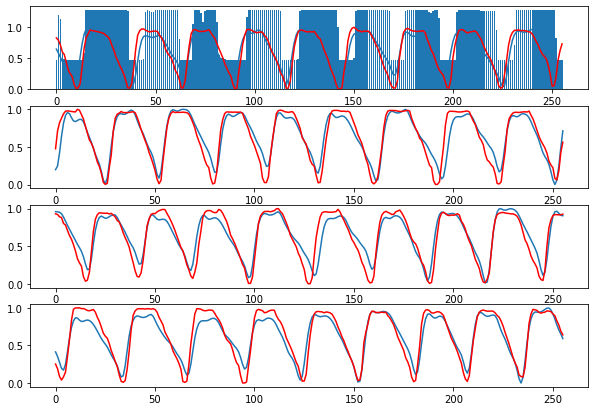

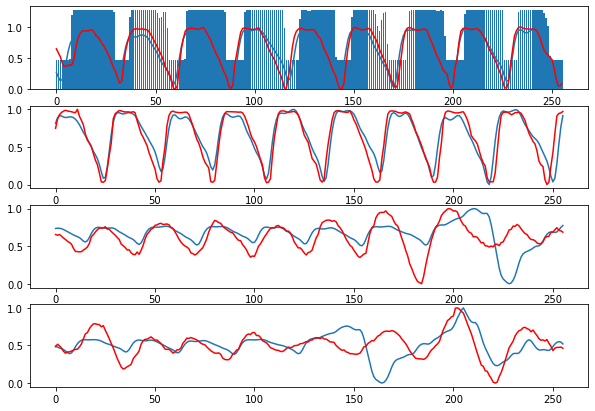

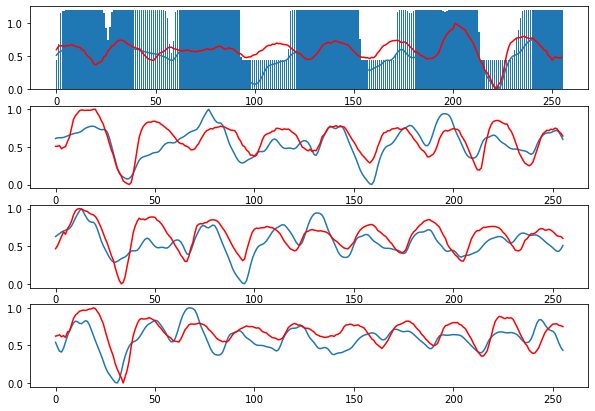

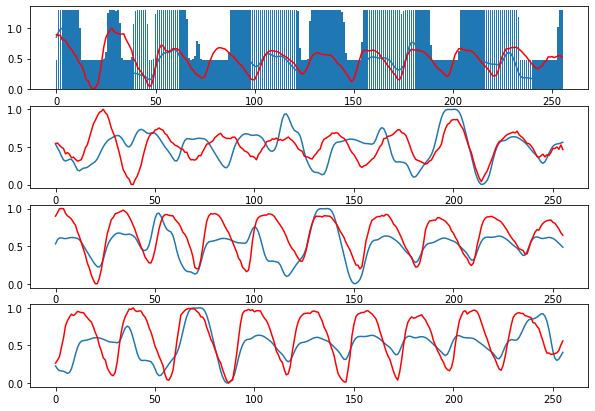

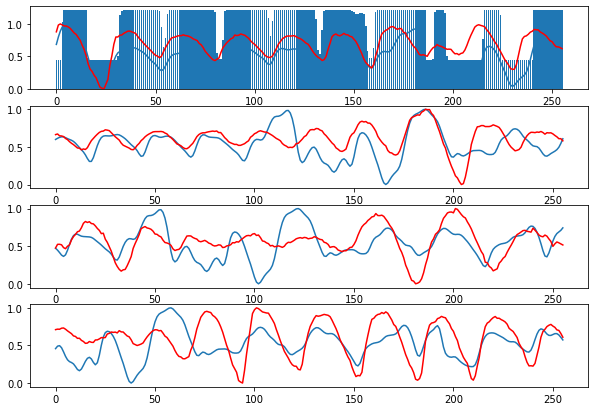

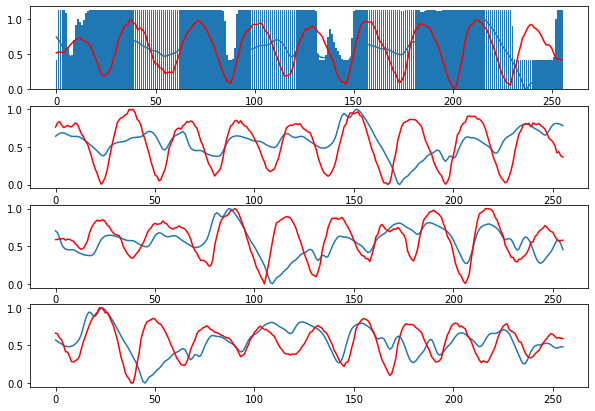

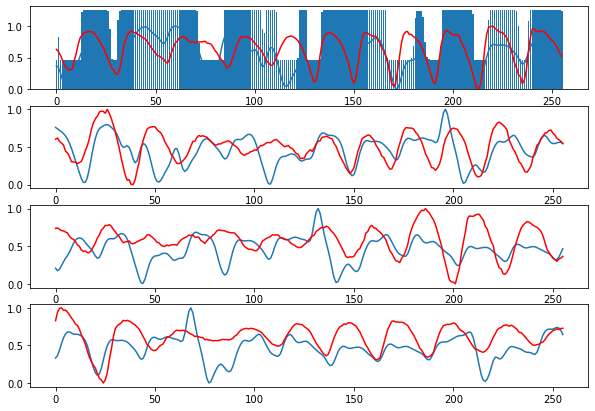

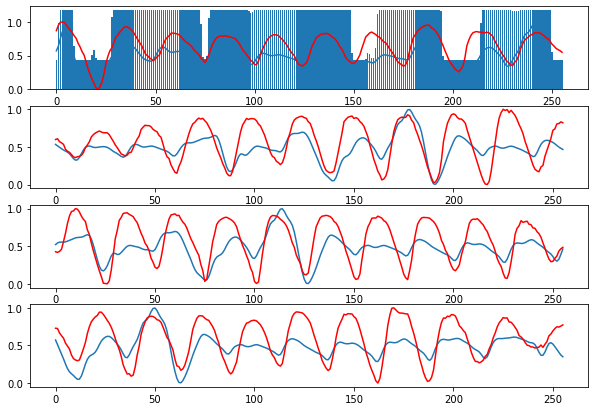

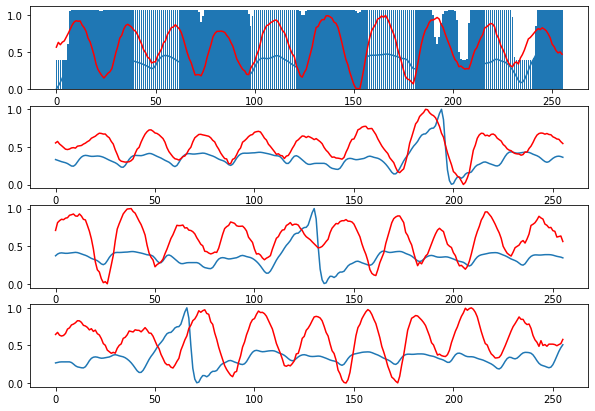

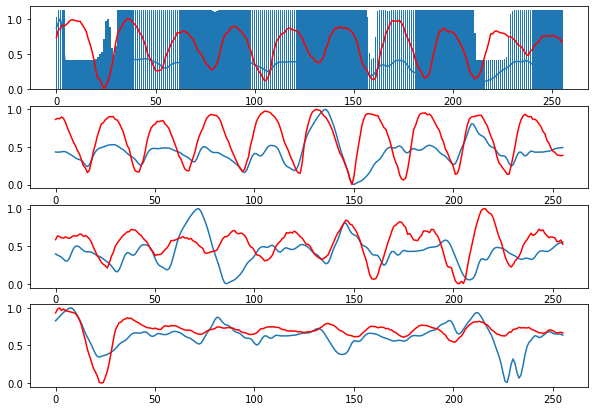

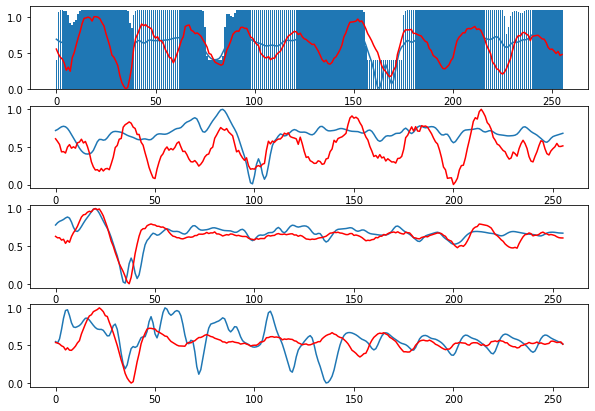

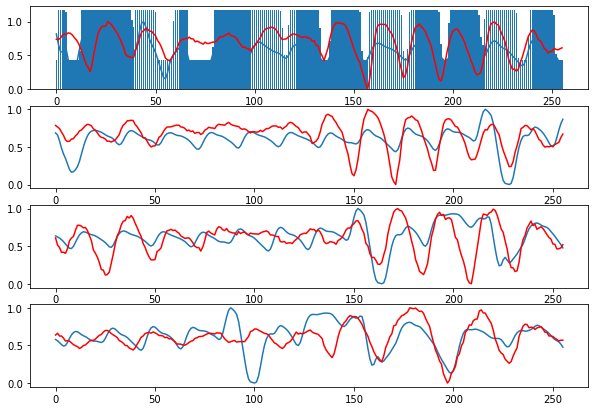

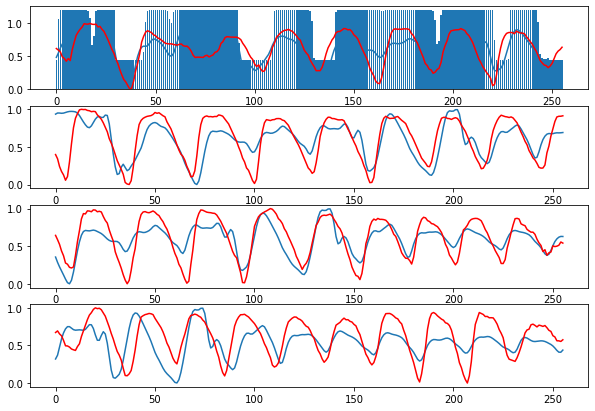

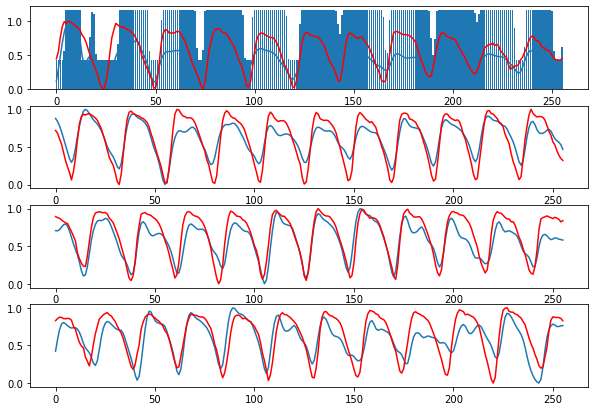

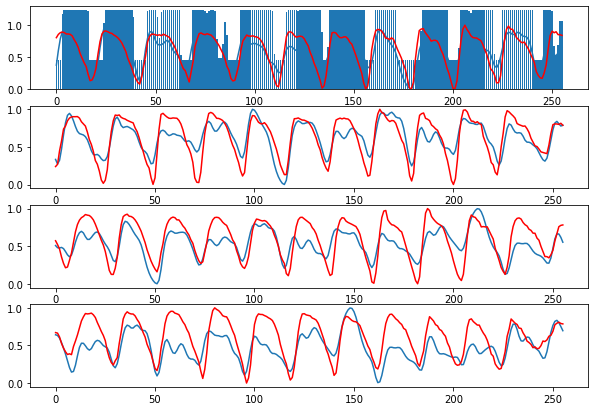

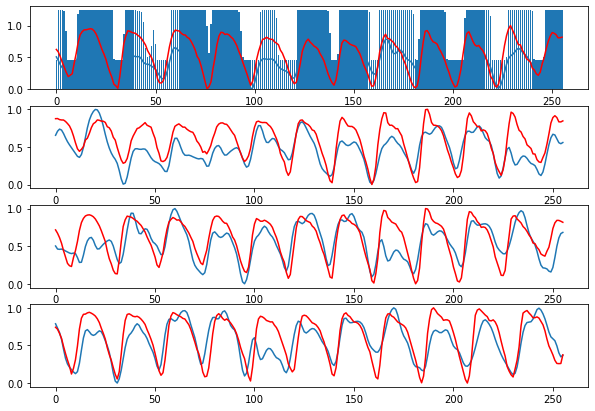

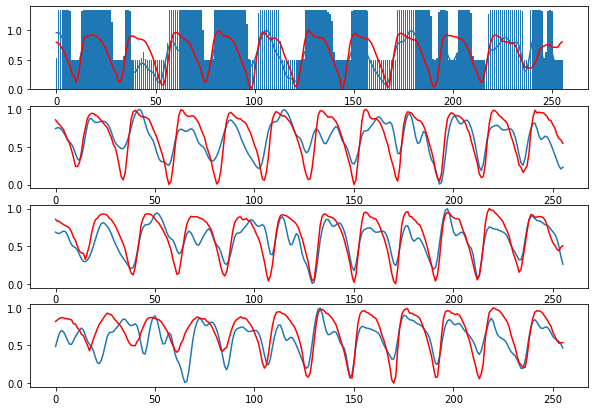

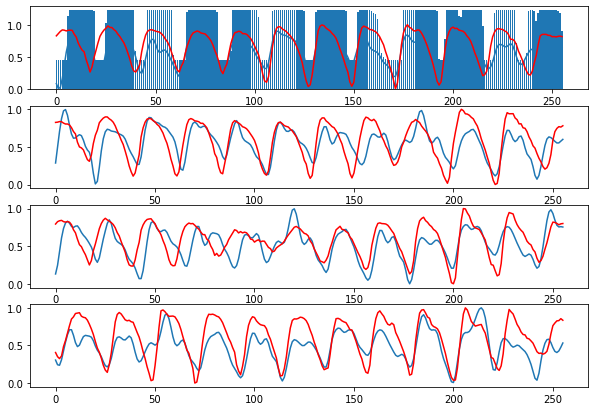

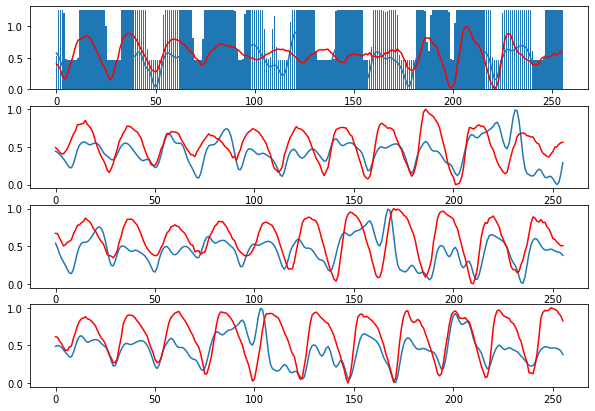

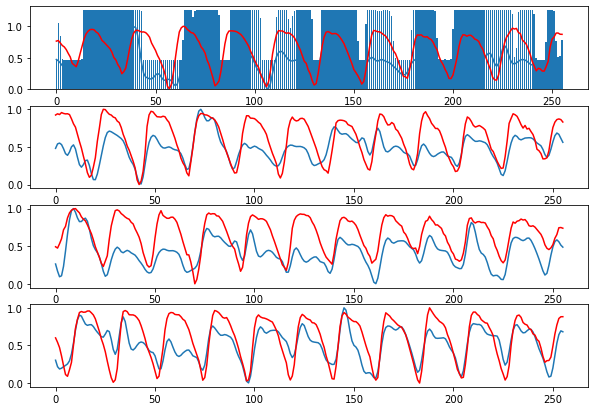

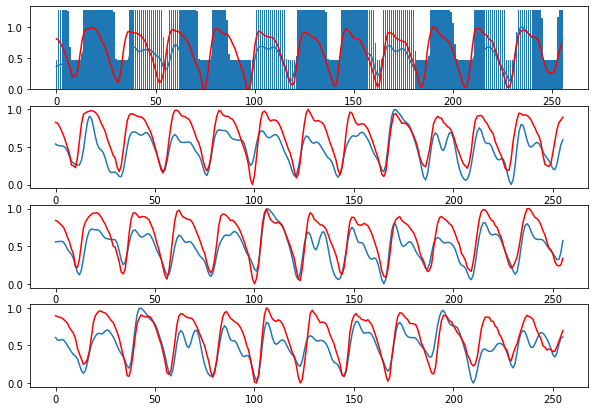

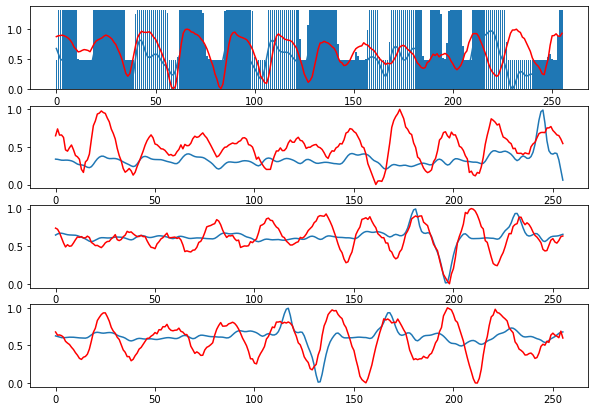

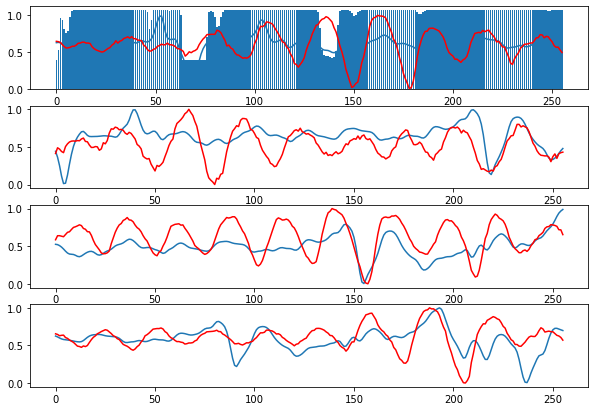

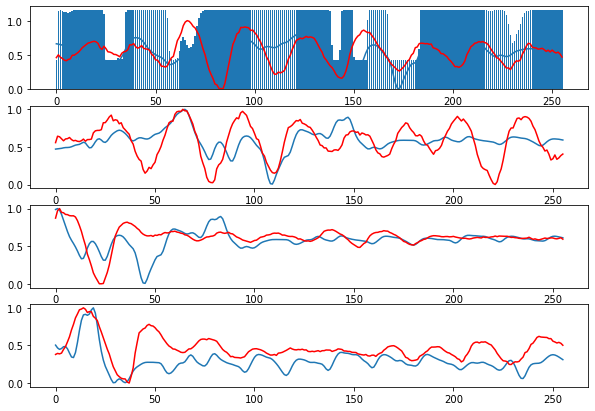

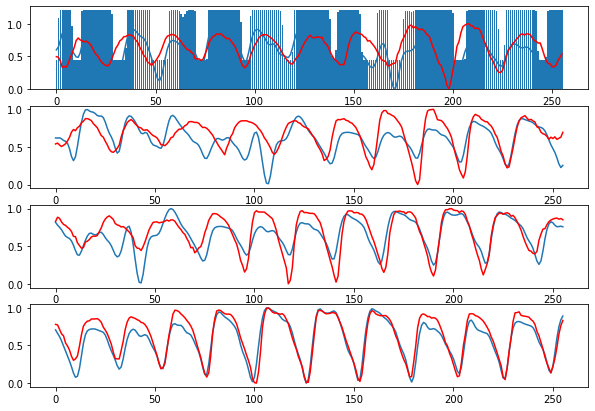

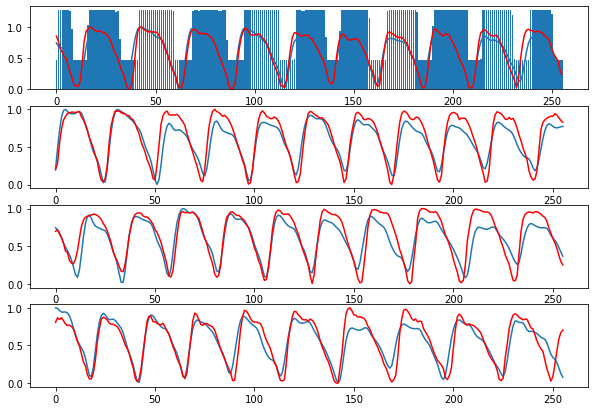

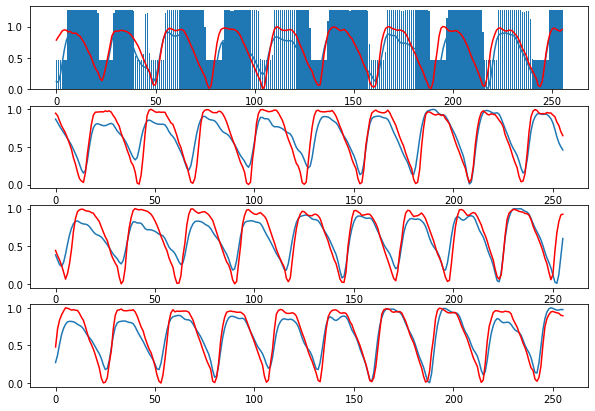

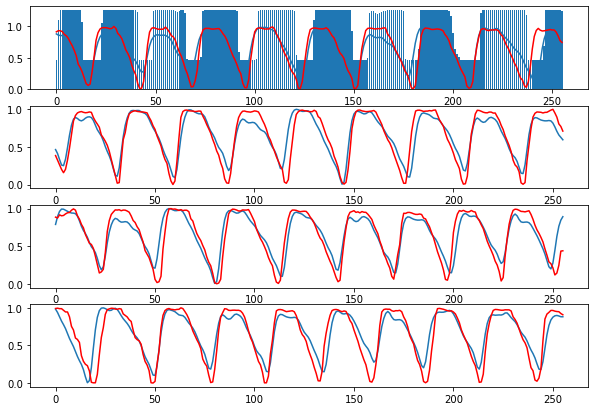

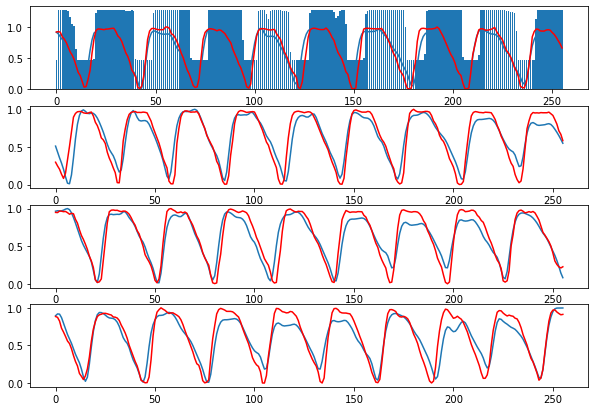

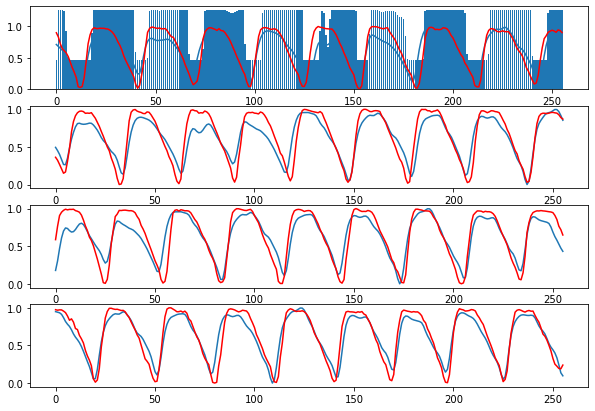

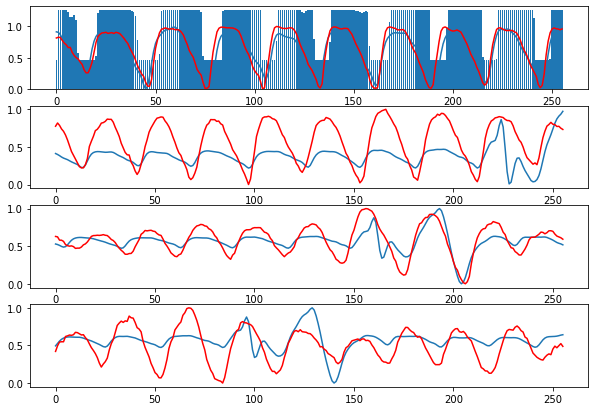

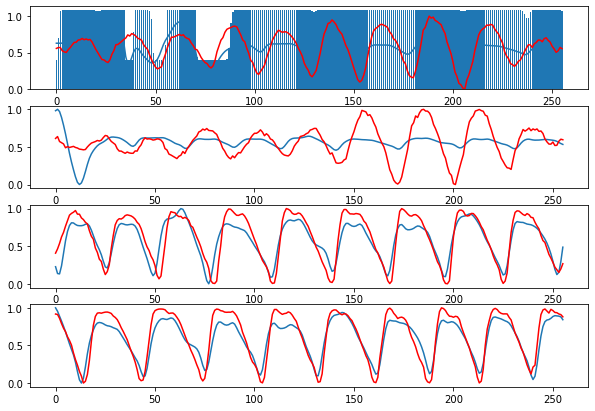

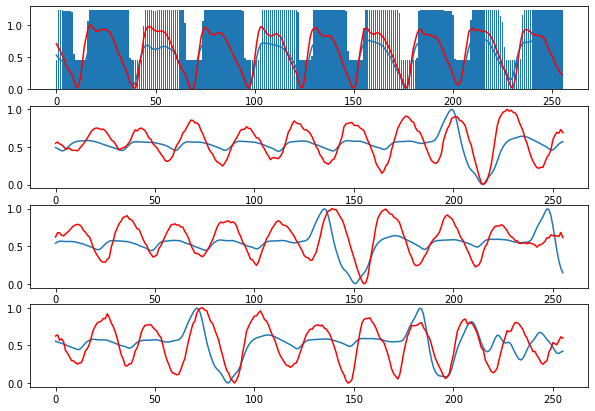

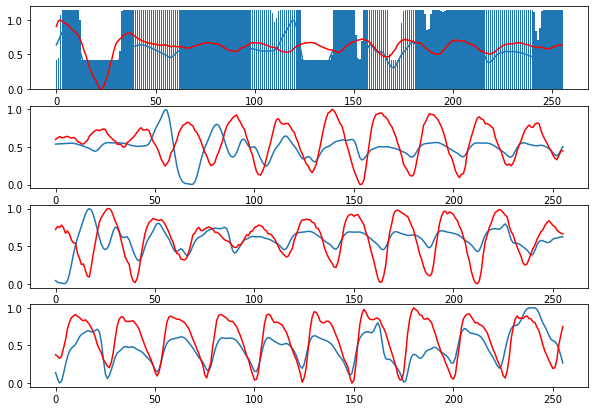

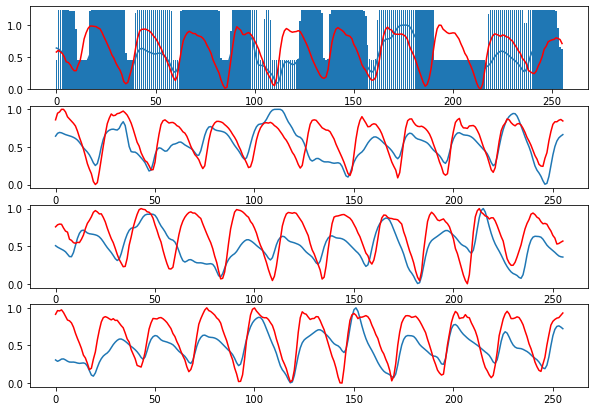

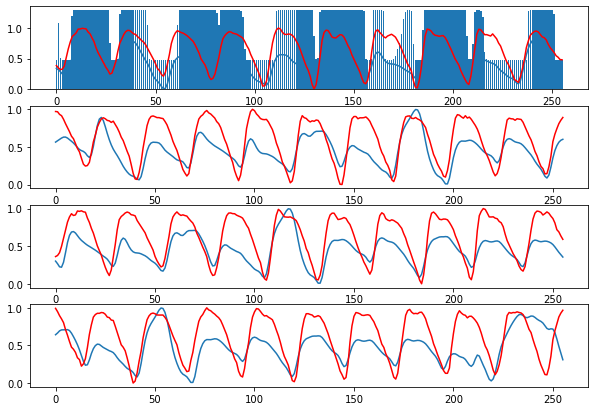

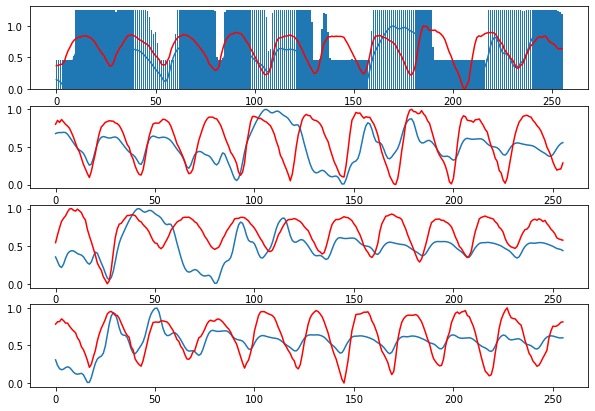

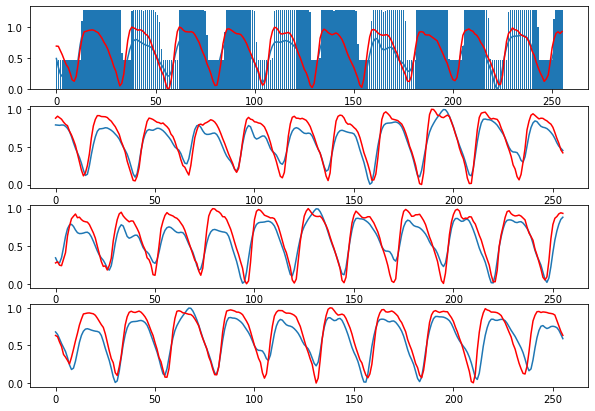

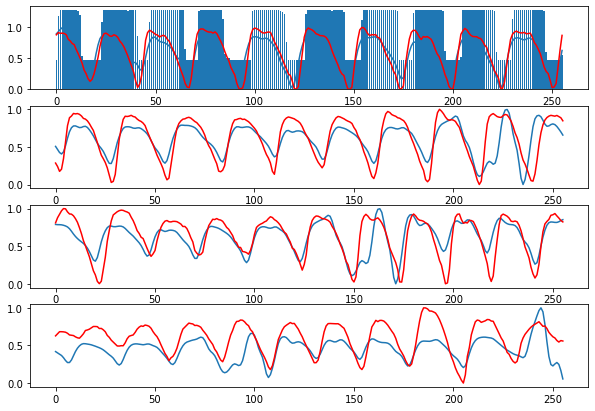

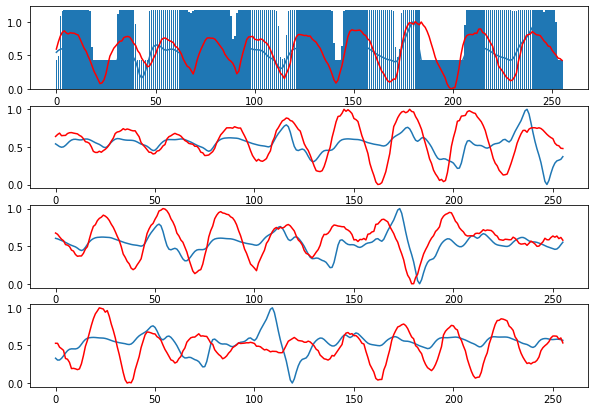

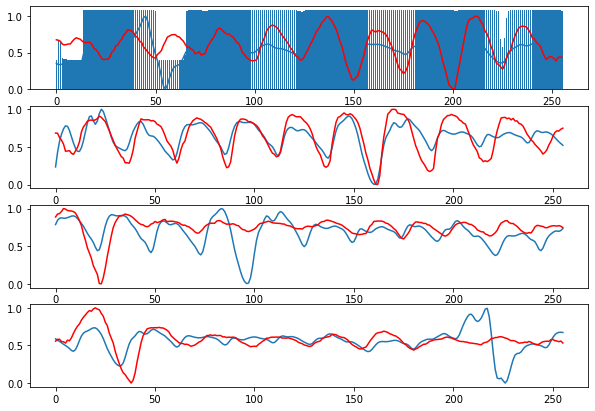

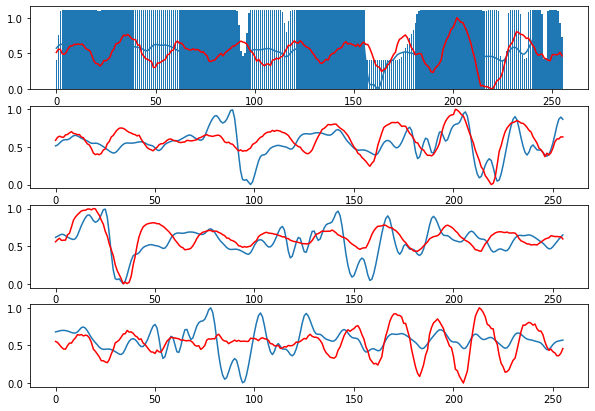

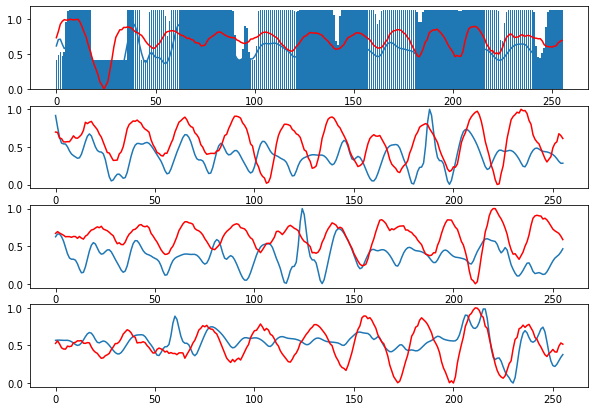

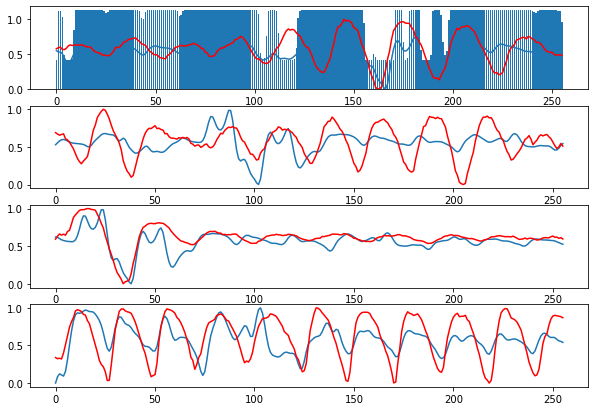

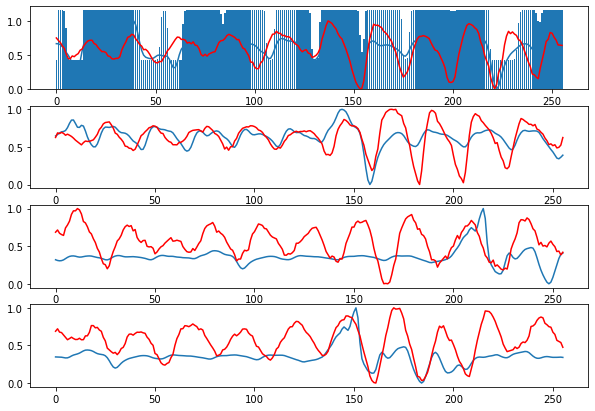

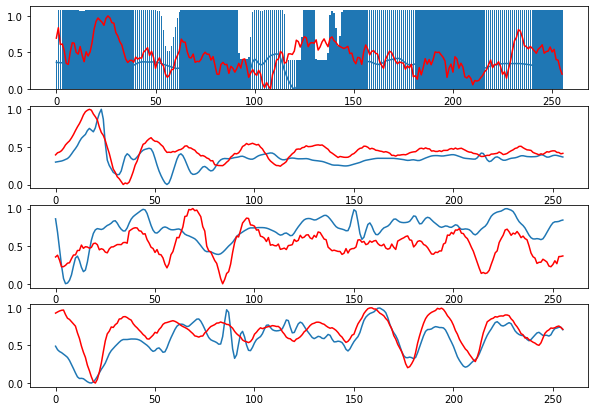

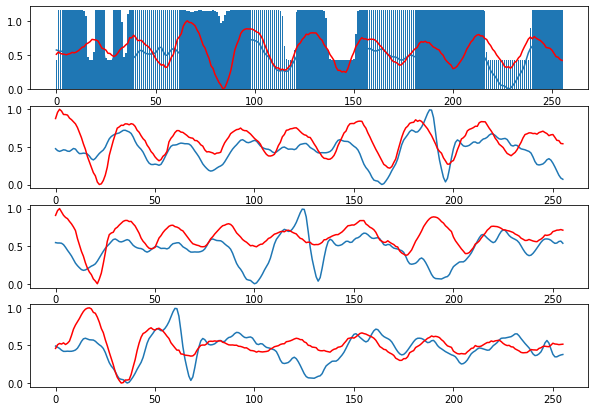

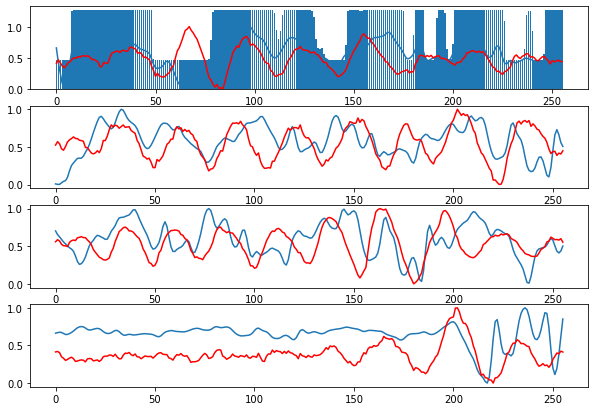

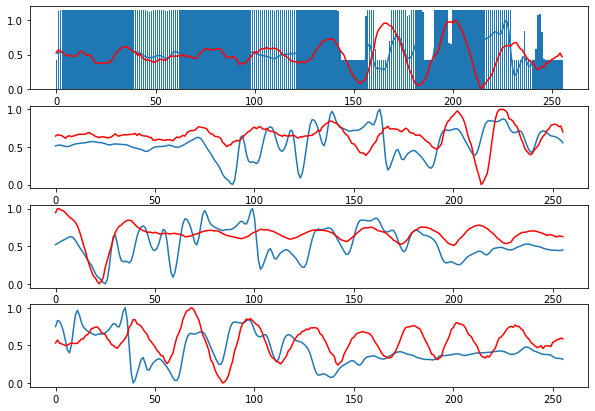

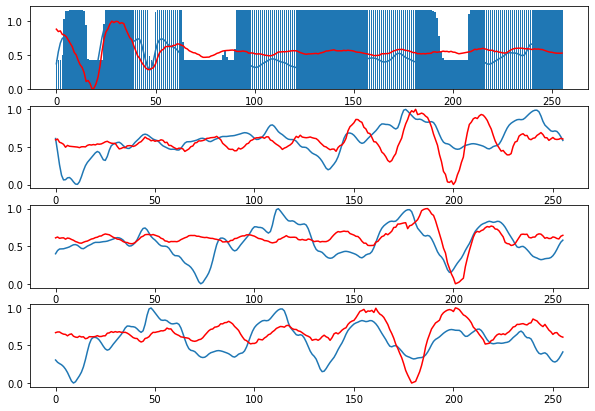

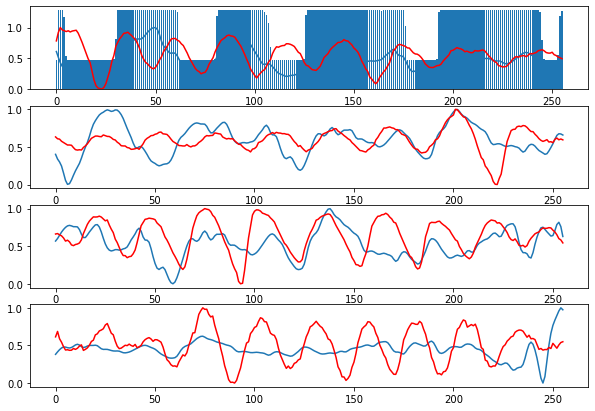

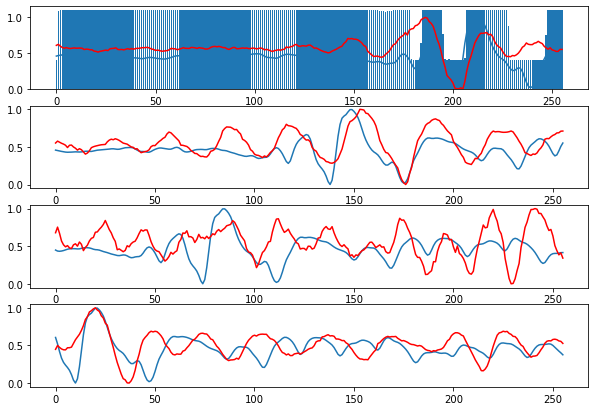

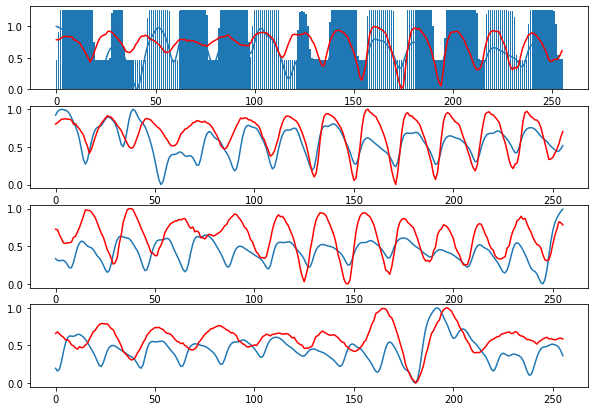

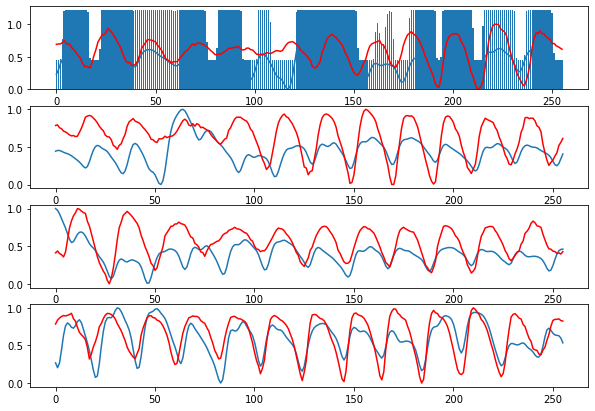

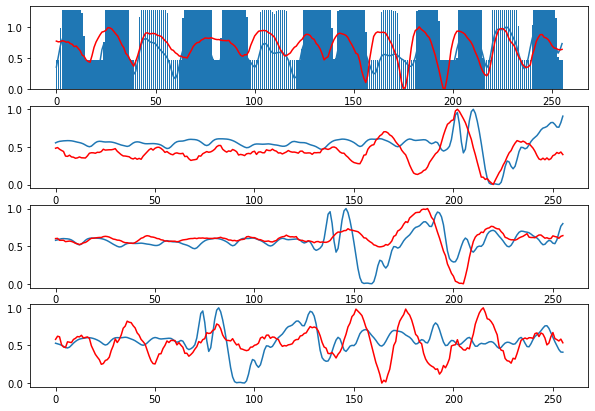

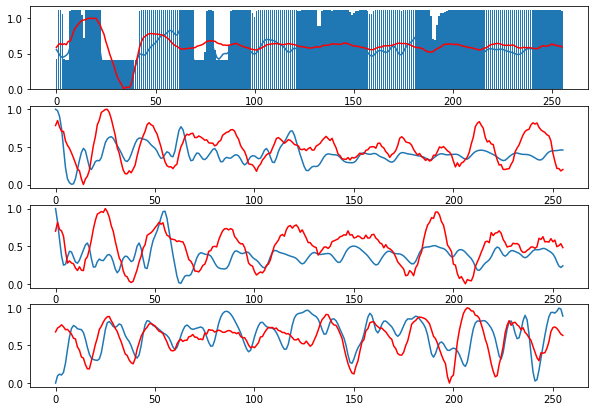

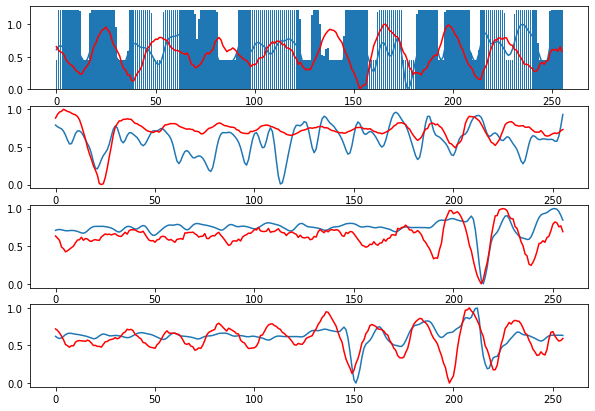

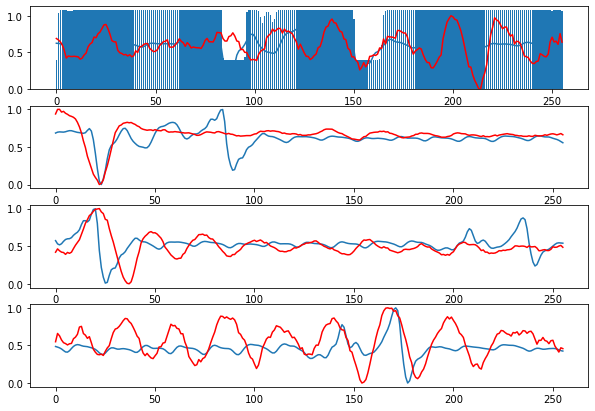

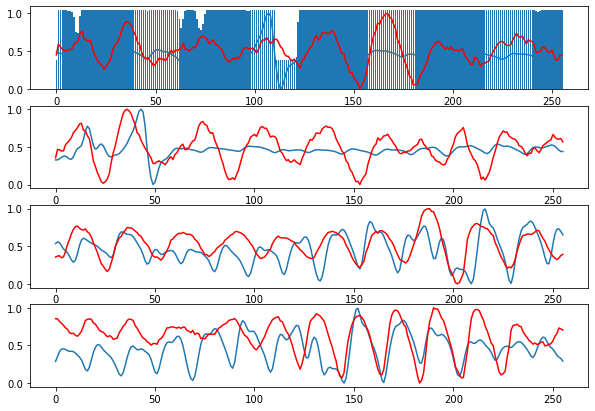

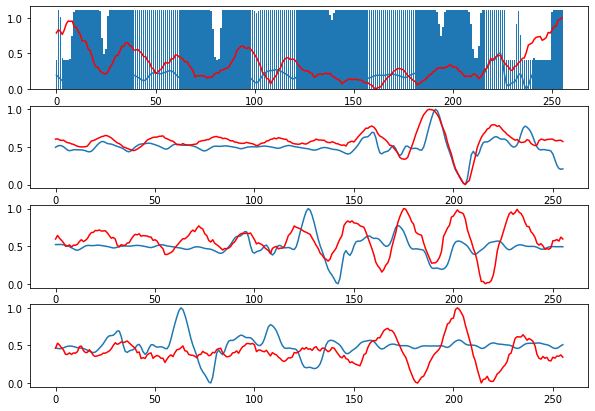

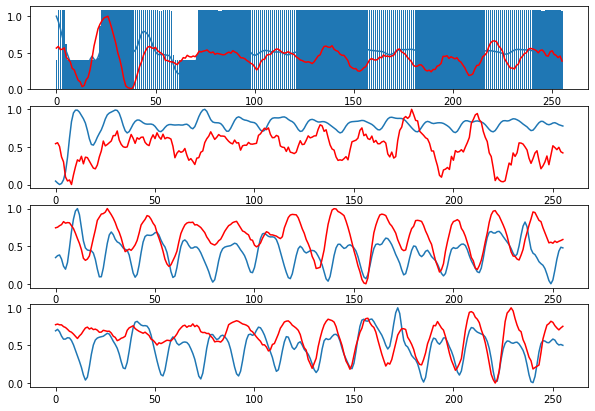

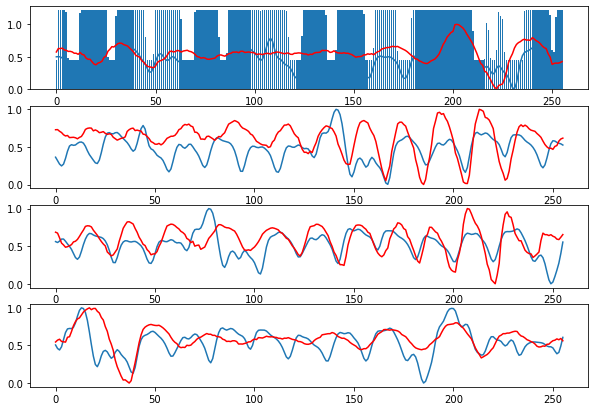

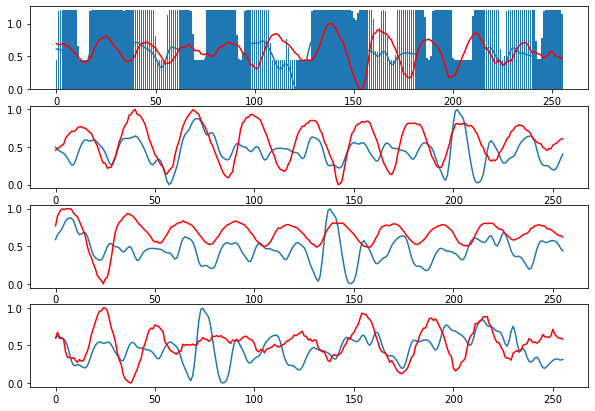

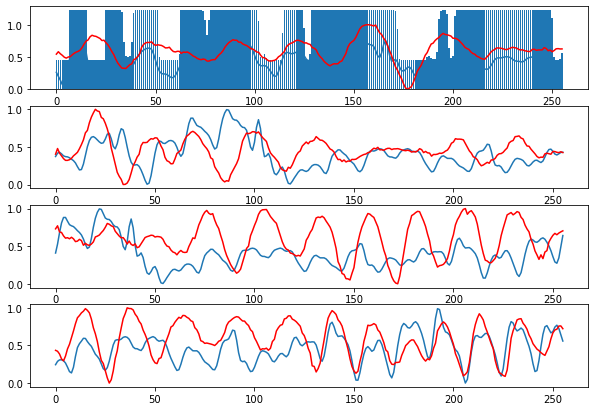

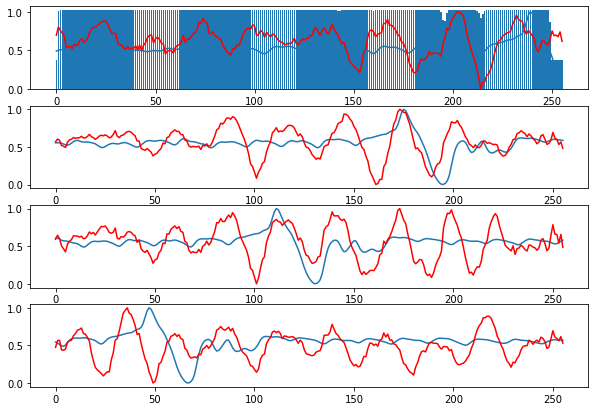

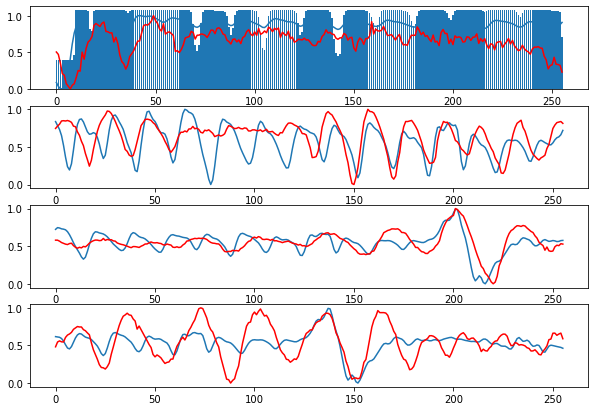

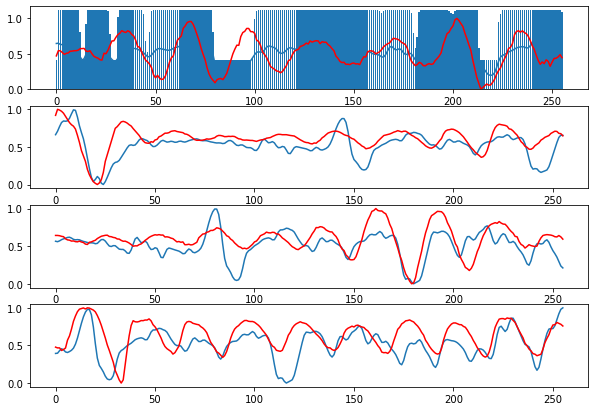

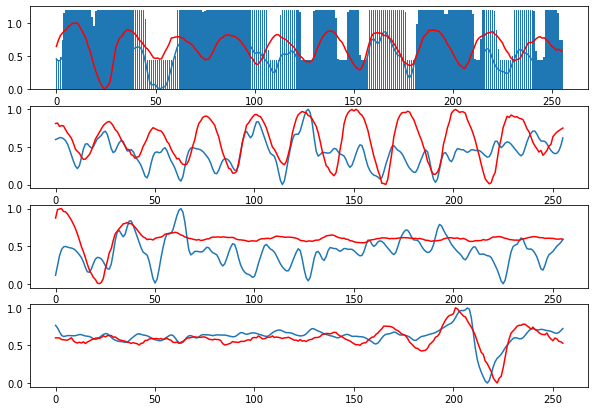

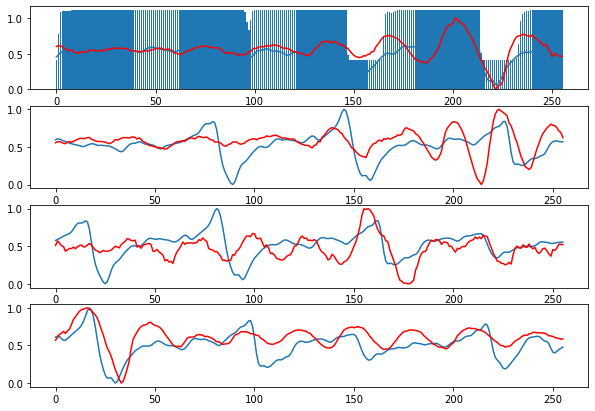

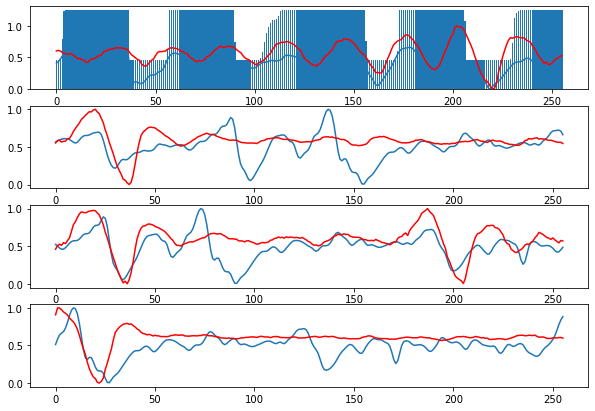

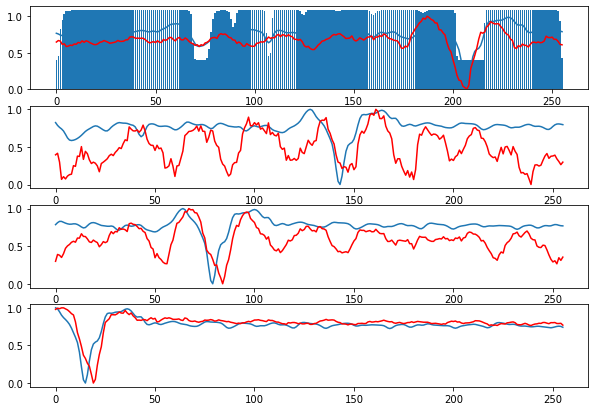

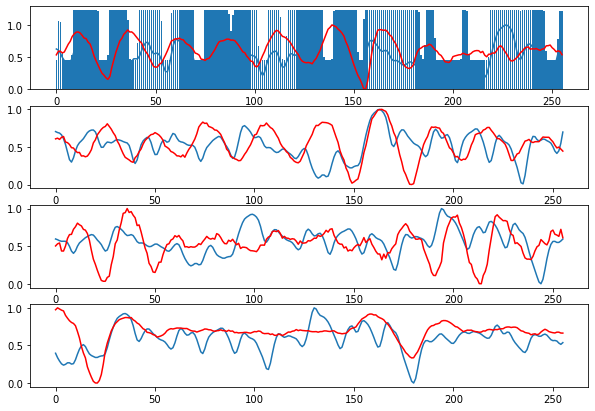

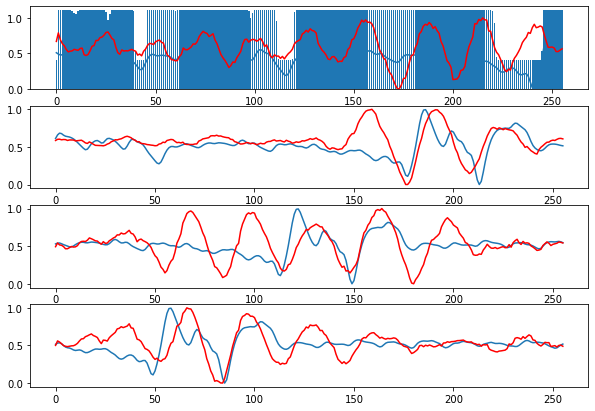

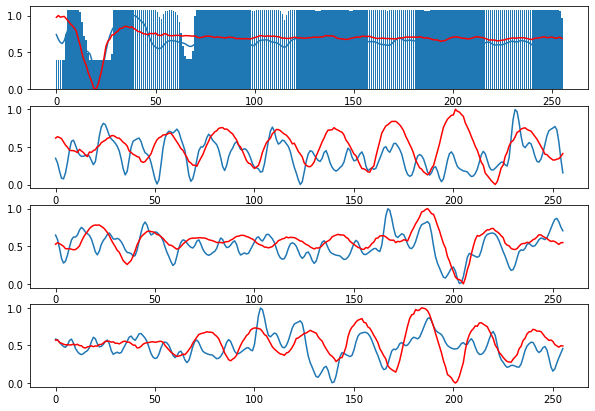

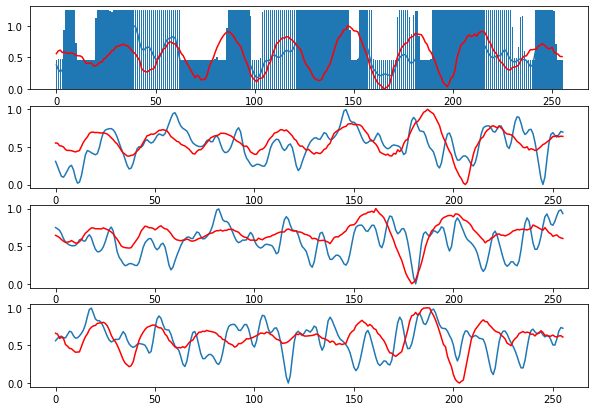

In [126]:
def custom_loss(y_true,y_pred):
    y_pred_attention = 1+y_pred[:,:,1]
    y_pred = y_pred[:,:,0]
    y_true = y_true[:,:,0]
    loss = K.mean(K.square(y_true-y_pred)*y_pred_attention)
    return loss

import keras.losses
keras.losses.custom_loss = custom_loss
from keras.models import model_from_json
json_file = open(model_filepath, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(filepath)

test_y_pred = model.predict(test_x)
test_y_pred_att = test_y_pred[:,:,1].reshape(-1,256,1)
test_y_pred = test_y_pred[:,:,0].reshape(-1,256,1)

for k in range(test_y_pred.shape[0]):
    test_y_pred[k]  = MinMaxScaler().fit_transform(test_y_pred[k])

%matplotlib inline
for i in range(600,900,4):
    
    fig,ax = plt.subplots(4,1,figsize=(10,7))
    ax[0].plot(test_y[i])
    ax[0].plot(test_y_pred[i],'r')
    ax[0].bar(np.array(list(range(256))),test_y_pred_att[i].reshape(-1),.8)
    
    ax[1].plot(test_y[i+1])
    ax[1].plot(test_y_pred[i+1],'r')
    ax[2].plot(test_y[i+2])
    ax[2].plot(test_y_pred[i+2],'r')
    ax[3].plot(test_y[i+3])
    ax[3].plot(test_y_pred[i+3],'r')
    
    plt.show()



In [24]:
y_pred_attention = 1+y_pred[:,:,1]
    y_pred = y_pred[:,:,0]
    y_true = y_true[:,:,0]
    loss = K.sum(K.square(y_true-y_pred)*y_pred_attention)

IndentationError: unexpected indent (<ipython-input-24-bf11438045ff>, line 2)

In [68]:
test_y_pred_att

array([[[0.0194663 ],
        [0.01402935],
        [0.01057811],
        ...,
        [0.0092735 ],
        [0.01230255],
        [0.02068709]],

       [[0.02245263],
        [0.016595  ],
        [0.01274893],
        ...,
        [0.00939631],
        [0.0124062 ],
        [0.02066338]],

       [[0.02552951],
        [0.01927997],
        [0.01420288],
        ...,
        [0.00914429],
        [0.01222077],
        [0.02072514]],

       ...,

       [[0.02368994],
        [0.01718747],
        [0.01301126],
        ...,
        [0.00975859],
        [0.01283286],
        [0.02182434]],

       [[0.0229666 ],
        [0.01663608],
        [0.01261273],
        ...,
        [0.00916685],
        [0.01211728],
        [0.020863  ]],

       [[0.02321721],
        [0.01683053],
        [0.01273369],
        ...,
        [0.00955291],
        [0.01270316],
        [0.02180321]]], dtype=float32)

In [53]:
y_pred = K.variable(np.random.uniform(0,2,(500,256,2)))

In [48]:
y_pred_attention = 1+y_pred[:,:,1]
y_pred = y_pred[:,:,0]

In [49]:
y_true = K.variable(np.random.uniform(0,2,(500,256,1)))

In [50]:
y_true = y_true[:,:,0]

In [51]:
K.mean(K.sqrt(K.square(y_true-y_pred)*y_pred_attention))

<tf.Tensor: shape=(), dtype=float32, numpy=0.9367105>

In [54]:
K.mean(y_pred[:,:,1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.99995047>